In [14]:
# reader beware: this is, by far, the worst-structured notebook i have ever written

import pandas as pd
import numpy as np

In [15]:
earn_df = pd.read_stata("../data/earn_and_edu.dta")
earn_df.head()

edu_cats = {
    "bachelor's degree": 1,
    "4 years of college": 1, # Assumption that 4 years of college equates to a
                             # bachelors degree - needed in order to get approx
                             # college information from years prior to the
                             # "bachelor's degree" classification.

    "12th grade, diploma unclear": 0,
    "high school diploma or equivalent": 0
}

# Apply critera to data
earn_df = earn_df[
    (earn_df["educ"].isin(edu_cats.keys())) &
    (earn_df["sex"] == "male") &
    (earn_df["inctot"] > 0) &
    (earn_df["inctot"] < 99999997)
]

earn_df["educ"] = earn_df["educ"].map(edu_cats).astype(int)

earn_df = pd.DataFrame(earn_df.to_numpy(), columns=earn_df.columns)
earn_df.sort_values(["year", "inctot"], inplace=True)

earn_df.head()

,year,serial,month,hwtfinl,cpsid,asecflag,hflag,asecwth,pernum,wtfinl,cpsidp,asecwt,sex,educ,inctot,incwage,incbus,incfarm
653,1962,1865,march,NaN,NaN,NaN,NaN,1551.2,1,NaN,NaN,1551.2,male,0,1,0,1,0
1215,1962,4962,march,NaN,NaN,NaN,NaN,1376.36,1,NaN,NaN,1376.36,male,0,1,0,0,1
2659,1962,11306,march,NaN,NaN,NaN,NaN,1673.56,1,NaN,NaN,1673.56,male,0,1,0,1,0
2682,1962,11386,march,NaN,NaN,NaN,NaN,1531.62,1,NaN,NaN,1531.62,male,0,1,0,1,0
3249,1962,14114,march,NaN,NaN,NaN,NaN,1709.19,1,NaN,NaN,1709.19,male,0,1,0,1,0


In [16]:
# Add quantile labels for grouping
earn_df["decile"] = pd.Series(np.zeros(len(earn_df)))

# Weighted deciling is a royal pain in the ass.
for year in earn_df["year"].unique():
    subset = earn_df[earn_df["year"] == year]
    decile = pd.Series(np.zeros(len(subset)) + 0.1)
    decile.index = subset.index

    cumsum = subset["asecwt"].cumsum()
    for d in range(9):
        cutoff = subset["asecwt"].sum() * (d + 1) * 0.1
        decile.loc[subset["asecwt"][cumsum >= cutoff].index] += 0.1

    earn_df["decile"] = earn_df["decile"].add(decile, fill_value = 0)

earn_df["decile"] *= 10.001
earn_df["decile"] = earn_df["decile"].astype(int)

earn_df["decile"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
earn_df["inctot"] = earn_df["inctot"].astype(float)
earn_df["asecwt"] = earn_df["asecwt"].astype(float)
earn_df["incwt"] =  earn_df["inctot"] * earn_df["asecwt"]

all_groups = earn_df.groupby(
    by=["year"]
)

dec_groups = earn_df.groupby(
    by=["year", "decile"]
)

edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

<AxesSubplot:xlabel='year'>

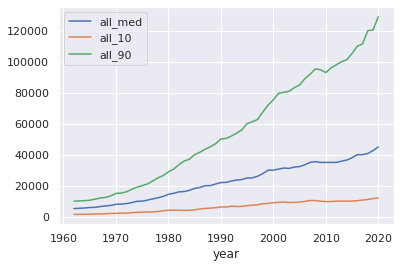

In [18]:
df = pd.DataFrame()

df["col_count"]  = edu_groups.count()["serial"].loc[:, 1] / all_groups.count()["serial"]
df["all_10"]    = dec_groups.max()["inctot"].loc[:, 1]
df["all_90"]    = dec_groups.min()["inctot"].loc[:, 10]
df["all_med"]  =  dec_groups.max()["inctot"].loc[:, 5]
df["all_avg"]  =  all_groups.sum()["incwt"] / all_groups.sum()["asecwt"]

df["top_share"] = dec_groups.sum()["inctot"].loc[:, 10]  / all_groups.sum()["inctot"]

df[["all_med", "all_10", "all_90"]].plot()

In [19]:
earn_df = pd.read_stata("../data/earn_and_edu.dta")
earn_df.head()

edu_cats = {
    "bachelor's degree": 1,
    "4 years of college": 1, # Assumption that 4 years of college equates to a
                             # bachelors degree - needed in order to get approx
                             # college information from years prior to the
                             # "bachelor's degree" classification.

    "12th grade, diploma unclear": 0,
    "high school diploma or equivalent": 0
}

# Apply critera to data
earn_df = earn_df[
    (earn_df["educ"].isin(edu_cats.keys())) &
    (earn_df["sex"] == "male") &
    (earn_df["inctot"] > 0) &
    (earn_df["inctot"] < 99999997)
]

earn_df["educ"] = earn_df["educ"].map(edu_cats).astype(int)

earn_df = pd.DataFrame(earn_df.to_numpy(), columns=earn_df.columns)
earn_df.sort_values(["year", "inctot"], inplace=True)

earn_df.head()


,year,serial,month,hwtfinl,cpsid,asecflag,hflag,asecwth,pernum,wtfinl,cpsidp,asecwt,sex,educ,inctot,incwage,incbus,incfarm
653,1962,1865,march,NaN,NaN,NaN,NaN,1551.2,1,NaN,NaN,1551.2,male,0,1,0,1,0
1215,1962,4962,march,NaN,NaN,NaN,NaN,1376.36,1,NaN,NaN,1376.36,male,0,1,0,0,1
2659,1962,11306,march,NaN,NaN,NaN,NaN,1673.56,1,NaN,NaN,1673.56,male,0,1,0,1,0
2682,1962,11386,march,NaN,NaN,NaN,NaN,1531.62,1,NaN,NaN,1531.62,male,0,1,0,1,0
3249,1962,14114,march,NaN,NaN,NaN,NaN,1709.19,1,NaN,NaN,1709.19,male,0,1,0,1,0


In [20]:
edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

all_groups = earn_df.groupby(
    by=["year"]
)

earn_df["asecwt"] = earn_df["asecwt"].astype(float)

baseline = 1962
col_rates = edu_groups.sum()["asecwt"].loc[:,1] / all_groups.sum()["asecwt"]
alt_rates = col_rates + (col_rates.index - baseline) * 0.0025
positive = alt_rates / col_rates
negative = (1 - alt_rates) / (1 - col_rates)

earn_df["modifier"] = earn_df.apply(
    axis = 1,
    func = lambda x: positive.loc[x["year"]] if x["educ"] == 1 else negative.loc[x["year"]]
)

earn_df["modifier"]
earn_df["mod_asecwt"] = earn_df["asecwt"] * earn_df["modifier"]

<AxesSubplot:xlabel='year'>

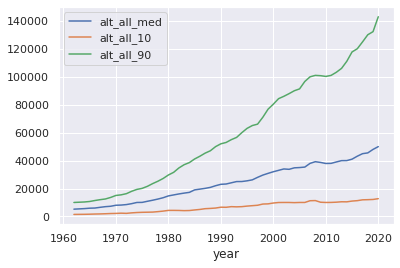

In [21]:

# Add quantile labels for grouping
earn_df["decile"] = pd.Series(np.zeros(len(earn_df)))

# Weighted deciling is a royal pain in the ass.
for year in earn_df["year"].unique():
    subset = earn_df[earn_df["year"] == year]
    decile = pd.Series(np.zeros(len(subset)) + 0.1)
    decile.index = subset.index

    cumsum = subset["mod_asecwt"].cumsum()
    for d in range(9):
        cutoff = subset["mod_asecwt"].sum() * (d + 1) * 0.1
        decile.loc[subset["mod_asecwt"][cumsum >= cutoff].index] += 0.1

    earn_df["decile"] = earn_df["decile"].add(decile, fill_value = 0)

earn_df["decile"] *= 10.001
earn_df["decile"] = earn_df["decile"].astype(int)

earn_df["decile"].unique()

earn_df["inctot"] = earn_df["inctot"].astype(float)
earn_df["mod_asecwt"] = earn_df["mod_asecwt"].astype(float)
earn_df["mod_incwt"] =  earn_df["inctot"] * earn_df["mod_asecwt"]

all_groups = earn_df.groupby(
    by=["year"]
)

dec_groups = earn_df.groupby(
    by=["year", "decile"]
)

edu_groups = earn_df.groupby(
    by=["year", "educ"]
)

df["alt_col_count"]  = edu_groups.sum()["mod_asecwt"].loc[:, 1] / all_groups.sum()["mod_asecwt"]
df["alt_all_10"]    = dec_groups.max()["inctot"].loc[:, 1]
df["alt_all_90"]    = dec_groups.min()["inctot"].loc[:, 10]
df["alt_all_med"]  =  dec_groups.max()["inctot"].loc[:, 5]
df["alt_all_avg"]  =  all_groups.sum()["mod_incwt"] / all_groups.sum()["mod_asecwt"]

df["alt_top_share"] = dec_groups.sum()["inctot"].loc[:, 10]  / all_groups.sum()["inctot"]

df[["alt_all_med", "alt_all_10", "alt_all_90"]].plot()

In [22]:
from fredapi import Fred

key = ""
with open(f"../assets/fred.key", "r") as file:
    key = file.read()
fred = Fred(api_key = key)

features = "PCEPI".split()
fred_df = pd.DataFrame()
for f in features:
    series = fred.get_series(f)
    series.name = f
    fred_df[f] = series

baseline = 1962
fred_df = fred_df[(fred_df.index.month == 4) & (fred_df.index.year >= baseline)]
fred_df.index = fred_df.index.year

fred_df["PCEPI"] /= fred_df["PCEPI"].iloc[-1]

fred_df.head()

,PCEPI
1962,0.152618
1963,0.153998
1964,0.156586
1965,0.158620
1966,0.162379


In [23]:
adj_cols = [
    "alt_all_avg", "alt_all_med", "alt_all_10", "alt_all_90",
    "all_avg", "all_med", "all_10", "all_90",
]

for col in adj_cols:
    df[col] /= fred_df["PCEPI"]

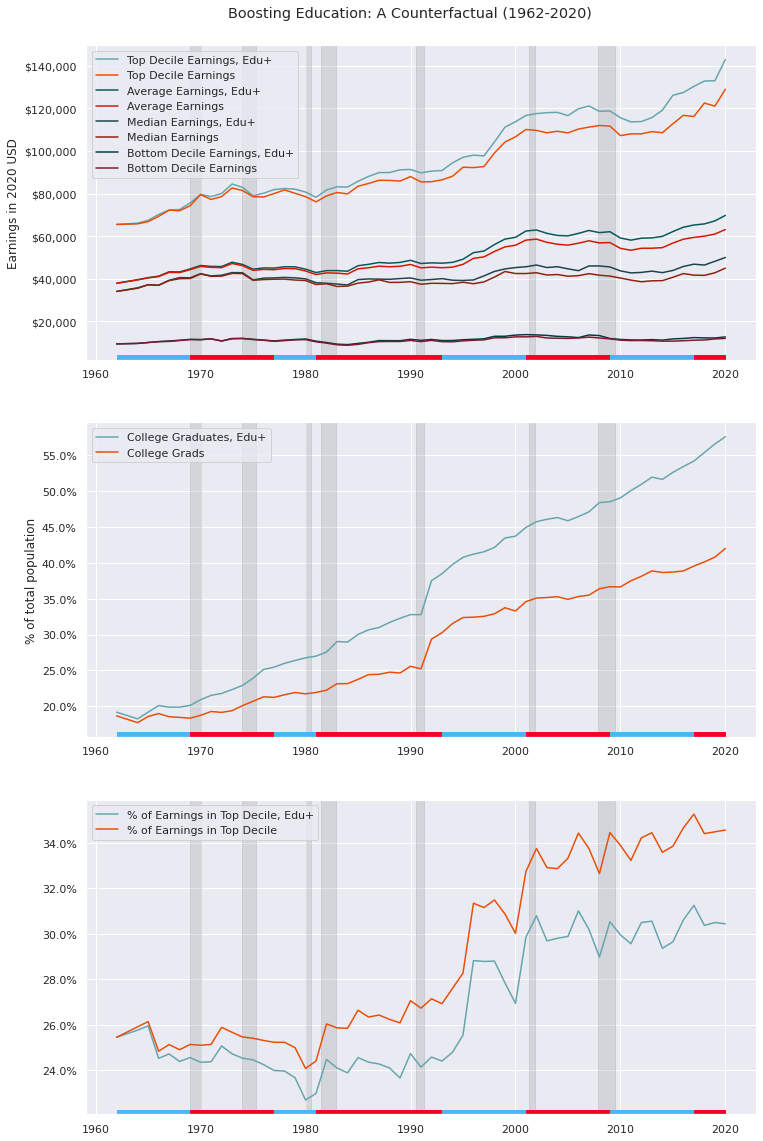

In [51]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotlib.ticker as mtick

presidents = [
    [1962, "#4cb5f5"],
    [1963, "#4cb5f5"],
    [1969, "#f70025"],
    [1974, "#f70025"],
    [1977, "#4cb5f5"],
    [1981, "#f70025"],
    [1989, "#f70025"],
    [1993, "#4cb5f5"],
    [2001, "#f70025"],
    [2009, "#4cb5f5"],
    [2017, "#f70025"],
    [2020, "_"],
]

recessions = [
    [1969, 1970],
    [1973.9, 1975.25],
    [1980, 1980.5],
    [1981.5, 1982.9],
    [1990.5, 1991.25],
    [2001.25, 2001.9],
    [2007.9, 2009.5],
]

sns.set_theme()

fig: plt.Figure = plt.figure(figsize=(12, 18))
plt.suptitle("Boosting Education: A Counterfactual (1962-2020)")
fig.subplots_adjust(top=0.95)
gs = GridSpec(nrows=3, ncols=1)

ax0 = fig.add_subplot(gs[0,:])
ax0.plot(df["alt_all_90"],  color="#66a5ad", label="Top Decile Earnings, Edu+")
ax0.plot(df["all_90"],  color="#e94f08", label="Top Decile Earnings")

ax0.plot(df["alt_all_avg"], color="#07575b", label="Average Earnings, Edu+")
ax0.plot(df["all_avg"], color="#d61800", label="Average Earnings")

ax0.plot(df["alt_all_med"], color="#1e434c", label="Median Earnings, Edu+")
ax0.plot(df["all_med"], color="#8d230f", label="Median Earnings")

ax0.plot(df["alt_all_10"],  color="#003b46", label="Bottom Decile Earnings, Edu+")
ax0.plot(df["all_10"],  color="#7f192e", label="Bottom Decile Earnings")
ax0.yaxis.set_major_formatter('${x:,.0f}')
ax0.set_ylabel("Earnings in 2020 USD")

ax1 = fig.add_subplot(gs[1,:])
ax1.plot(df["alt_col_count"], color="#66a5ad", label="College Graduates, Edu+")
ax1.plot(df["col_count"],     color="#e94f08", label="College Grads")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax1.set_ylabel("% of total population")

ax2 = fig.add_subplot(gs[2,:])
ax2.plot(df["alt_top_share"], color="#66a5ad", label="Top Decile, Edu+")
ax2.plot(df["top_share"],     color="#e94f08", label="Top Decile")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax1.set_ylabel("% of total earnings")

for ax in fig.axes:
    ax.legend(loc="upper left")
    for i in range(len(recessions)):
        ax.axvspan(recessions[i][0], recessions[i][1], color="grey", alpha=0.2)

    for i in range(len(presidents) - 1):
        ax.axvspan(presidents[i][0], presidents[i + 1][0], color=presidents[i][1], alpha=1, ymin = 0, ymax=0.015)

plt.savefig("analysis.pdf")